In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from model import fit_dataarray, apply_model, deltaE_from_spectra
from radiometry import PTFE_reflectance_factor_45_0
from utils import standard_color

## First reference data
BCRA tile 0:45 reference from Malkin

In [2]:
reference = pd.read_excel('data/malkin set with test errors and assigned targets 10_18_18 and color calculations.xlsx',
                       sheet_name='target reflectance', usecols='A:M')
reference = reference.to_xarray()
reference = reference.set_coords('wavelength').to_array('tile').swap_dims({'index': 'wavelength'}).drop('index')
reference = reference.rename('reflectance')
reference['tile'] = [standard_color(c) for c in reference['tile'].values]

Since the measured dataset contains quite a bit of extra data, it has to be cleaned up to match references

In [3]:
ds = xr.open_dataset('data/refl.nc', chunks={'filename':1}).drop('_I50_L0-511_3-10-2018_11.21.28_2_Mid', dim='filename')
ds = ds.swap_dims({'band':'wavelength', 'filename':'tile'})
ds['tile'] = [standard_color(c) for c in ds['tile'].astype('U16').values]
measured = ds.isel(
    reference_filename=4
).where(
    (ds.distance=='near') & (ds.tile != 'none') & (ds.tile != 'white') & (ds.tile != 'Black'),
    drop=True
)['reflectance']

In [4]:
measured

<xarray.DataArray 'reflectance' (tile: 13, wavelength: 128, y: 696, x: 520)>
dask.array<shape=(13, 128, 696, 520), dtype=float64, chunksize=(1, 128, 696, 520)>
Coordinates:
    filename            (tile) object '_I50_L0-511_3-10-2018_11.16.3_PaleGrey_G' ... '_I50_L0-511_3-10-2018_13.30.50_12_DeepBlue_H'
    band                (wavelength) int64 1 2 3 4 5 6 ... 124 125 126 127 128
  * y                   (y) float64 0.5 1.5 2.5 3.5 ... 692.5 693.5 694.5 695.5
  * x                   (x) float64 0.5 1.5 2.5 3.5 ... 516.5 517.5 518.5 519.5
  * wavelength          (wavelength) float64 372.5 377.5 ... 1.038e+03 1.044e+03
  * tile                (tile) <U16 'pale gray' 'mid gray' ... 'deep blue'
    reference_filename  <U35 '_I50_L0-511_3-10-2018_13.50.8_PTFE_'

### Note
The wavelengths don't match exactly. For now we use linear interpolation to get matching values; Nearest neighbor lookup would result in duplication of some bands:

In [5]:
PTFE_reflectance_factor_45_0()

<xarray.DataArray (wavelength: 81)>
array([ 1.011,  1.011,  1.011,  1.011,  1.011,  1.011,  1.011,  1.011,  1.012,
        1.012,  1.012,  1.012,  1.012,  1.012,  1.012,  1.012,  1.012,  1.012,
        1.012,  1.012,  1.012,  1.012,  1.012,  1.012,  1.012,  1.012,  1.015,
        1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,
        1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,
        1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,
        1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,
        1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,
        1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015,  1.015])
Coordinates:
  * wavelength  (wavelength) int64 380 385 390 395 400 ... 760 765 770 775 780

In [6]:
bad_matches = np.where(
    np.histogram(measured.sel(wavelength=reference.wavelength, method='nearest').wavelength, bins=81)[0] != 1
)
measured.wavelength[bad_matches].data

array([ 407.471664,  539.477383,  622.335896,  643.243884,  722.337684,
        732.965702])

Additionally we'll use the reflectance factors for 0/45 to correct from the PTFE reference to ideal lambertian reflectance:

In [7]:
measurement_to_fit = measured.interp_like(reference, method='linear') / PTFE_reflectance_factor_45_0()

In [8]:
measurement_to_fit.name = 'reflectance'

In [9]:
measurement_to_fit = measurement_to_fit.chunk({'x':'auto', 'y':'auto'})
measurement_to_fit

<xarray.DataArray 'reflectance' (tile: 12, wavelength: 81, y: 696, x: 520)>
dask.array<shape=(12, 81, 696, 520), dtype=float64, chunksize=(1, 81, 348, 260)>
Coordinates:
  * tile                (tile) object 'pale gray' 'mid gray' ... 'deep blue'
    filename            (tile) object dask.array<shape=(12,), chunksize=(12,)>
    band                (wavelength) float64 dask.array<shape=(81,), chunksize=(81,)>
  * y                   (y) float64 0.5 1.5 2.5 3.5 ... 692.5 693.5 694.5 695.5
  * x                   (x) float64 0.5 1.5 2.5 3.5 ... 516.5 517.5 518.5 519.5
    reference_filename  <U35 '_I50_L0-511_3-10-2018_13.50.8_PTFE_'
  * wavelength          (wavelength) int64 380 385 390 395 ... 765 770 775 780

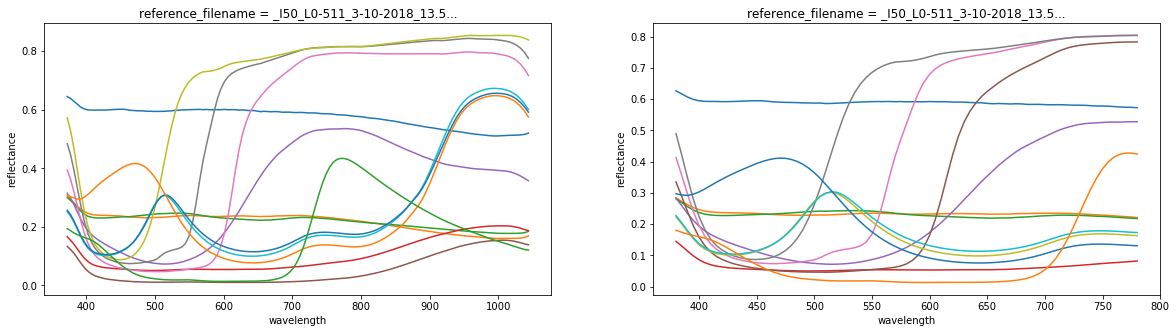

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
measured.mean(dim=['x','y']).plot.line(x='wavelength', ax=ax[0],add_legend=False)
measurement_to_fit.mean(dim=['x','y']).plot.line(x='wavelength', ax=ax[1],add_legend=False)
plt.show()

In [53]:
import model

In [38]:
list(measurement_to_fit.groupby('tile'))[0][1].squeeze()

<xarray.DataArray 'reflectance' (wavelength: 81, y: 696, x: 520)>
dask.array<shape=(81, 696, 520), dtype=float64, chunksize=(81, 348, 260)>
Coordinates:
    tile                <U4 'cyan'
    filename            object dask.array<shape=(), chunksize=()>
    band                (wavelength) float64 dask.array<shape=(81,), chunksize=(81,)>
  * y                   (y) float64 0.5 1.5 2.5 3.5 ... 692.5 693.5 694.5 695.5
  * x                   (x) float64 0.5 1.5 2.5 3.5 ... 516.5 517.5 518.5 519.5
    reference_filename  <U35 '_I50_L0-511_3-10-2018_13.50.8_PTFE_'
  * wavelength          (wavelength) int64 380 385 390 395 ... 765 770 775 780

In [57]:
def px_XYZ(ds):
    ds = ds.stack(px=['x','y']).squeeze()
    return model.spectra_to_XYZ(ds)

xyz_measurement = px_XYZ(measurement_to_fit.isel(tile=0))
#xyz_measurement = measurement_to_fit.groupby('tile', squeeze=True).apply(px_XYZ) / 100
#xyz_reference = reference.groupby('tile', squeeze=True).apply(model.spectra_to_XYZ) / 100

  File "/home/maaleske/miniconda3/envs/colortiles/lib/python3.7/site-packages/colour/utilities/verbose.py", line 277, in usage_warning
    warning(*args, **kwargs)
  File "/home/maaleske/miniconda3/envs/colortiles/lib/python3.7/site-packages/colour/utilities/verbose.py", line 221, in warning
    warn(*args, **kwargs)
/home/maaleske/miniconda3/envs/colortiles/lib/python3.7/site-packages/colour/utilities/verbose.py:221: ColourUsageWarning: "colour.ILLUMINANTS_RELATIVE_SPDS" object has been renamed to "colour.ILLUMINANTS_SDS".
  warn(*args, **kwargs)


ValueError: setting an array element with a sequence.

In [ ]:
rgb_measurement = xyz_measurement.groupby('tile').apply(XYZ_to_sRGB)
rgb_reference = xyz_reference.groupby('tile').apply(XYZ_to_sRGB)

In [ ]:
rgb_measurement.plot.imshow(col='tile', rgb='colour')

In [ ]:
rgb_reference.expand_dims('x').expand_dims('y').plot.imshow(col='tile')

In [ ]:
from colour.utilities import filter_warnings
filter_warnings()

def deltaE(x, y):
    def _deltaE(ds):
        ds['deltaE'] = deltaE_from_XYZ(ds['a'], ds['b'], method='CIE 1976', cmfs='CIE 2012 10 Degree Standard Observer')
        return ds.drop(['a','b'])
    
    def _deltaE_px(ds):
        return ds.stack(px=['x','y']).groupby('px').apply(_deltaE).unstack('px')
    
    ds = xr.Dataset(data_vars={'a':x, 'b':y})
    return ds.groupby('tile', squeeze=True).apply(_deltaE_px)

In [ ]:
deltaE(xyz_measurement, xyz_reference)['deltaE'].to_series().plot.barh()
for i, v in enumerate(deltaE(measurement_to_fit, reference)['deltaE'].values):
    plt.text(v + 0.5, i-0.2, v.round(decimals=2), color='k')

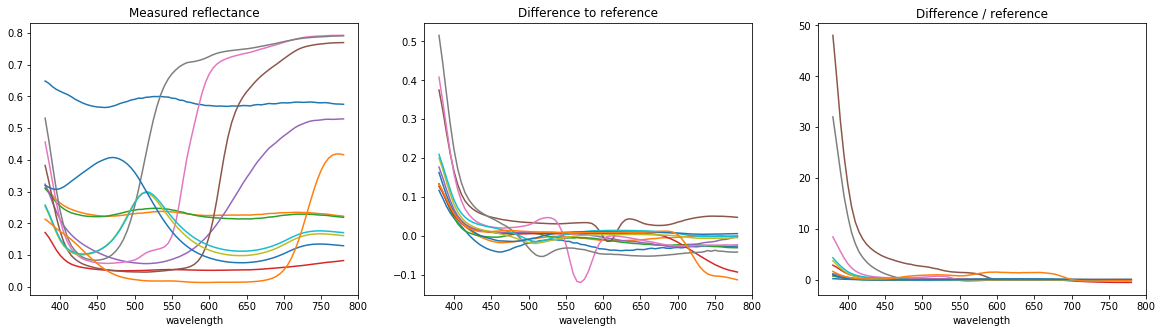

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
measurement_to_fit.plot.line(x='wavelength', ax=ax[0],add_legend=False)
(measurement_to_fit - reference).plot.line(x='wavelength', add_legend=False, ax=ax[1])
((measurement_to_fit - reference)/reference).plot.line(x='wavelength', add_legend=False, ax=ax[2])
ax[0].set_title('Measured reflectance')
ax[1].set_title('Difference to reference')
ax[2].set_title('Difference / reference')
plt.show()

## Fit of coefficients
Fit coefficients C1-C5 for the model of the difference
$$
\Delta R = R_{ref} - R = C_1 + C_2 R + C_3 \frac{\delta R}{\delta \lambda} + C4 \frac{\delta^2 R}{\delta \lambda^2} + C_5 (1 - R)R
$$
from
> Germer et. al., ''Spectrophotometry: Accurate Measurement of Optical Properties of Materials'', 
>vol.46, p.394

In [43]:
coefs = fit_dataarray(measurement_to_fit.load(), reference)

KeyboardInterrupt: 

Add the modeled difference to the measured reflectance and compare with the reference data:

In [27]:
reconstruction = apply_model(measurement_to_fit, coefs)

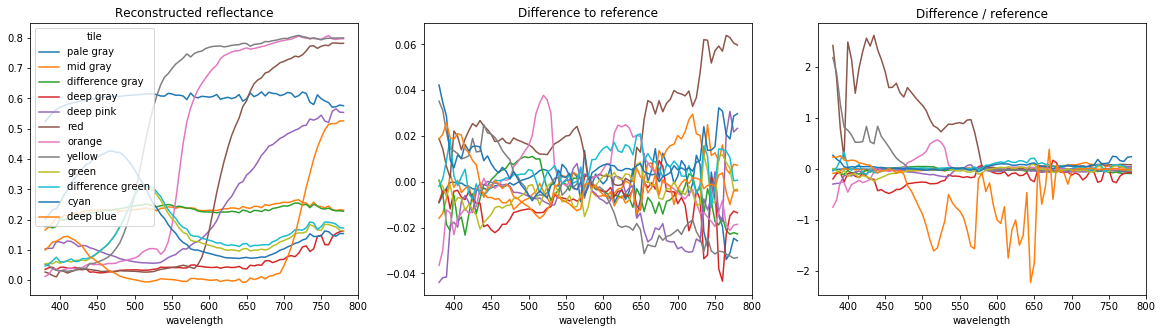

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
reconstruction.plot.line(ax=ax[0], x='wavelength')
(reconstruction - reference).plot.line(ax=ax[1], add_legend=False, x='wavelength')
((reconstruction - reference)/reference).plot.line(ax=ax[2], add_legend=False, x='wavelength')
ax[0].set_title('Reconstructed reflectance')
ax[1].set_title('Difference to reference')
ax[2].set_title('Difference / reference')
plt.show()

In [76]:
rgb_reconstruction = xr.apply_ufunc(XYZ_to_sRGB, reconstruction.groupby('tile', squeeze=True).apply(spectra_to_XYZ) / 100)

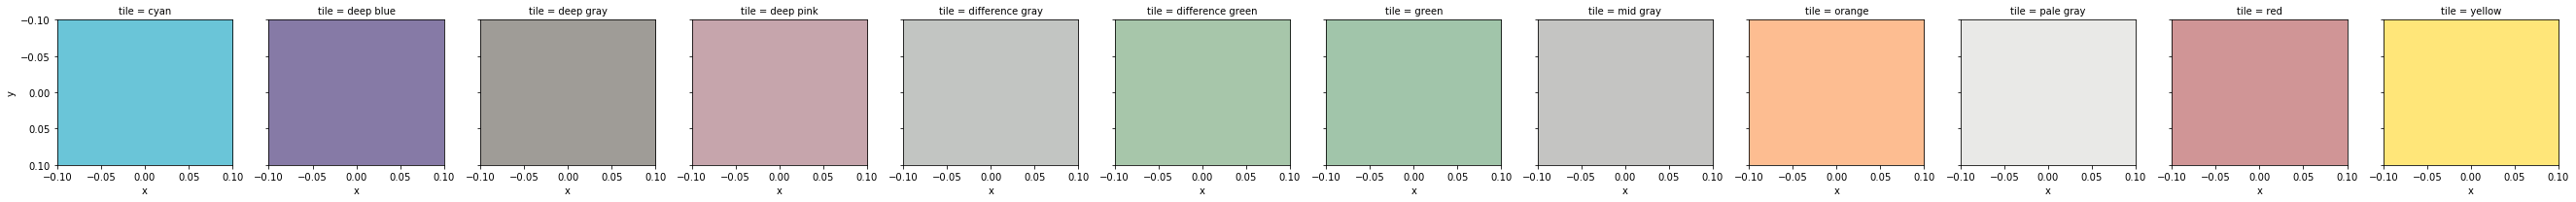

In [77]:
rgb_reconstruction.expand_dims('x').expand_dims('y').plot.imshow(col='tile')

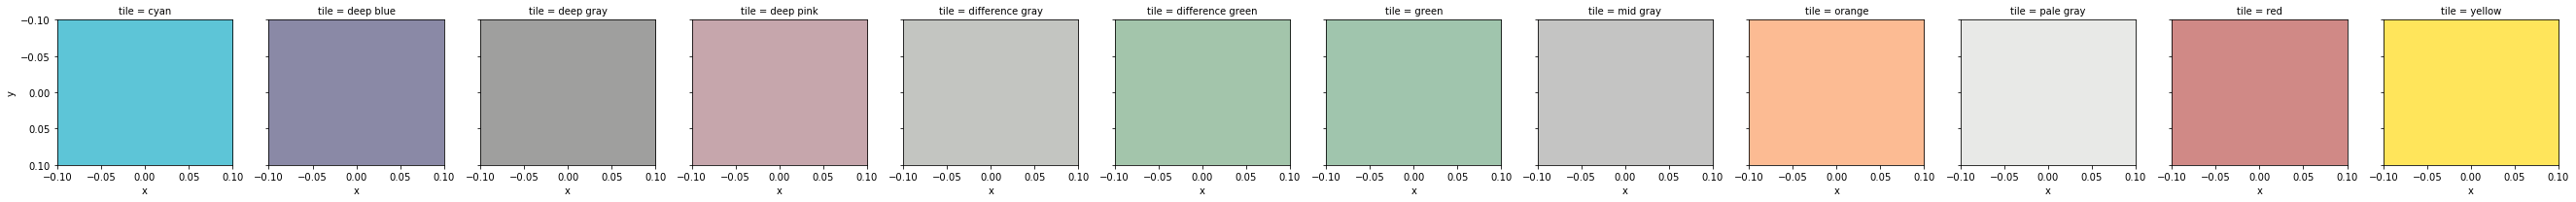

In [78]:
rgb_reference.expand_dims('x').expand_dims('y').plot.imshow(col='tile')

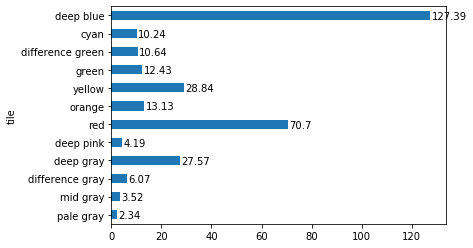

In [29]:
deltaE(reconstruction, reference)['deltaE'].to_series().plot.barh()
for i, v in enumerate(deltaE(reconstruction, reference)['deltaE'].values):
    plt.text(v + 0.5, i-0.2, v.round(decimals=2), color='k')

In [59]:
reco_df = reconstruction.drop(['band', 'reference_filename', 'filename']).to_dataset('tile').to_dataframe()
reco_df.to_csv('data/corrected_reflectances_malkin.csv')

### Coefficients
As defined by CZ in his Labview UI:

- C1: Offset
- C2: Span
- C3: Wavelength registration
- C4: Bandpass
- C5: Non-linearity

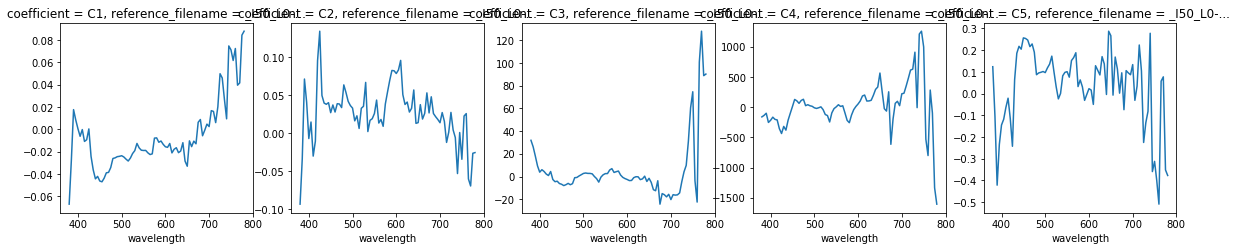

In [60]:
fig, ax = plt.subplots(ncols=5, figsize=(20,3.5))
for k, coef in enumerate(['C1', 'C2', 'C3', 'C4', 'C5']):
    coefs.sel(coefficient=coef).plot.line(x='wavelength', ax=ax[k])
plt.show()

## Second reference data

In [61]:
reference_cz = pd.read_excel('data/RSEX BEP1 CJZ measurements on Lambda 1050.xlsx',
                       sheet_name='reflectance', usecols='J:CM')
reference_cz.index = reference_cz['Artifact_Name']
reference_cz = reference_cz.drop(columns='Artifact_Name').transpose()
reference_cz.index = [int(s.split('_')[0]) for s in reference_cz.index]
reference_cz.index = reference_cz.index.rename('wavelength')
reference_cz = 0.01 * reference_cz.to_xarray().to_array('tile').drop(['PTFE'], dim='tile')
reference_cz['tile'] = [standard_color(s) for s in reference_cz.tile.values]

In [62]:
reference_cz.to_dataset('tile').to_dataframe().to_csv('data/reference_cz.csv')

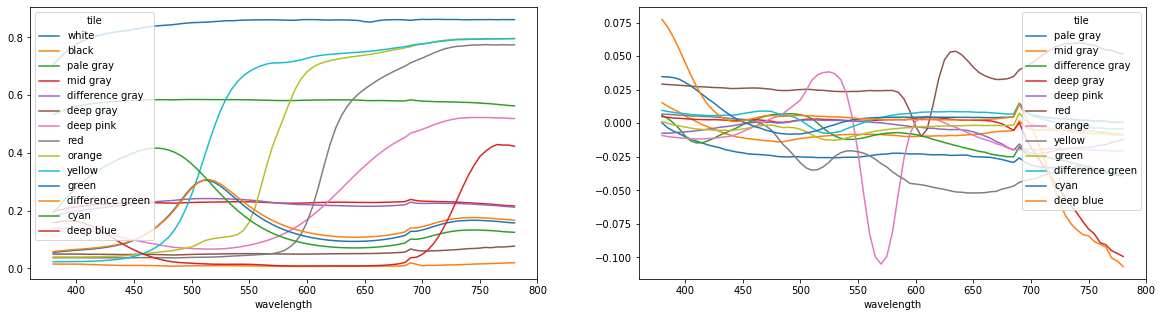

In [63]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
reference_cz.plot.line(x='wavelength', ax=ax[0])
(reference_cz - reference).plot.line(x='wavelength', ax=ax[1])
plt.show()

In [81]:
rgb_reference_cz = xr.apply_ufunc(XYZ_to_sRGB, reference_cz.groupby('tile', squeeze=True).apply(spectra_to_XYZ) / 100)

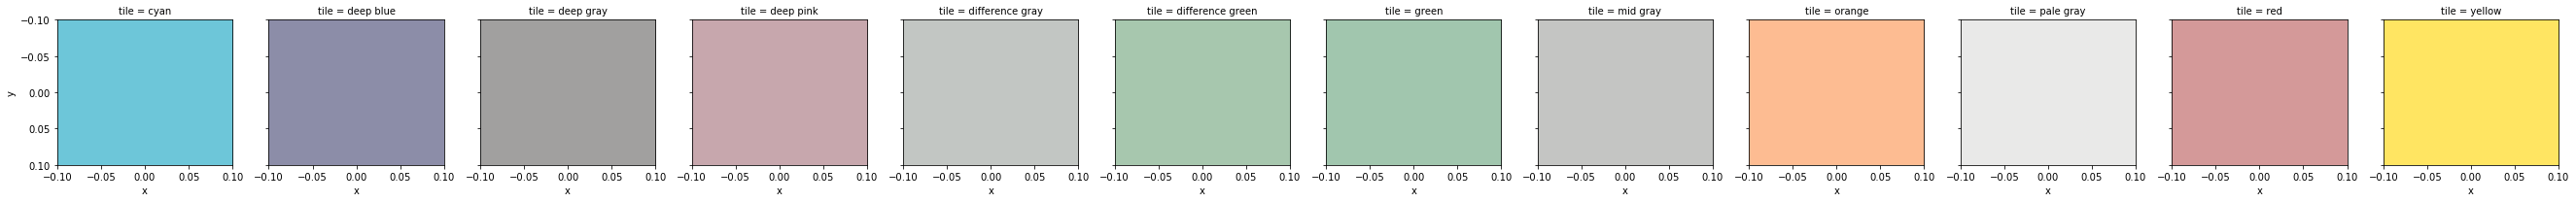

In [84]:
rgb_reference_cz.drop(['white', 'black'], dim='tile').expand_dims('x').expand_dims('y').plot.imshow(col='tile')

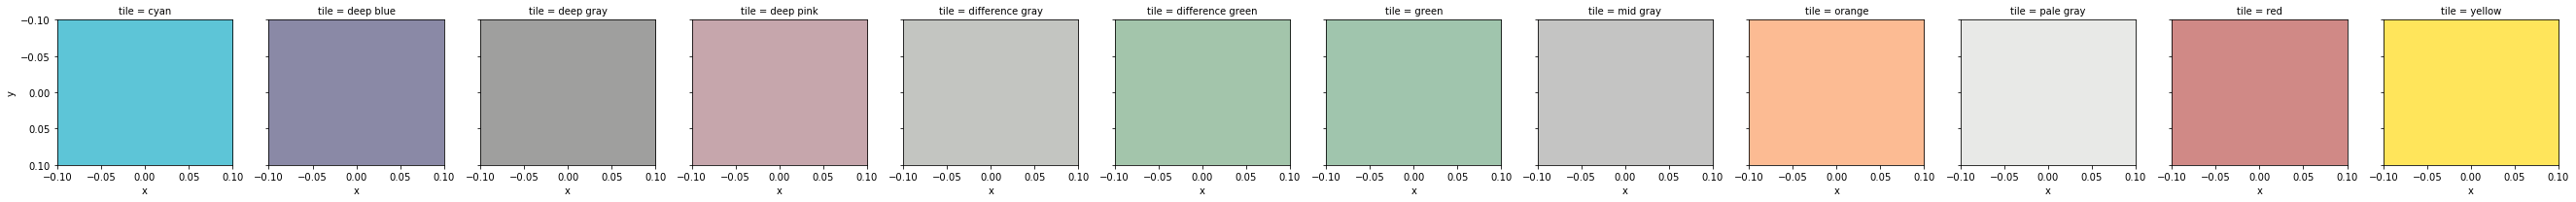

In [83]:
rgb_reference.expand_dims('x').expand_dims('y').plot.imshow(col='tile')

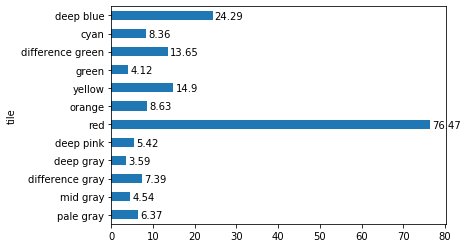

In [64]:
deltaE(reference_cz.drop(['white', 'black'], dim='tile'), reference)['deltaE'].to_series().plot.barh()
for i, v in enumerate(deltaE(reference_cz.drop(['white', 'black'], dim='tile'), reference)['deltaE'].values):
    plt.text(v + 0.5, i-0.2, v.round(decimals=2), color='k')

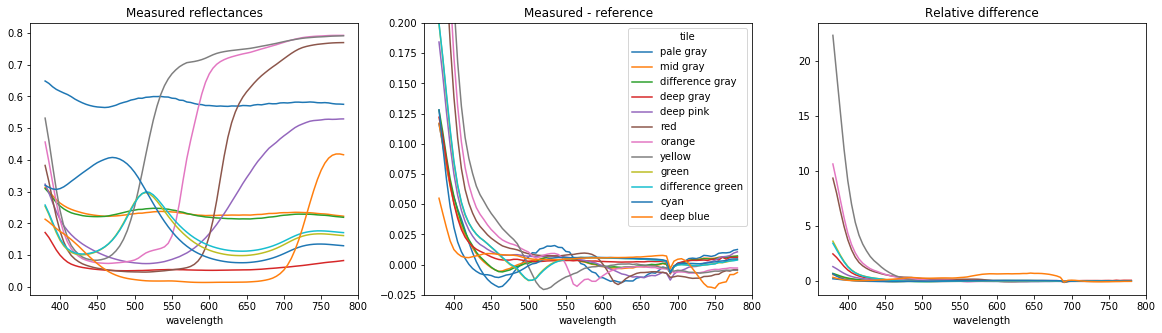

In [65]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
measurement_to_fit.plot.line(x='wavelength', ax=ax[0],add_legend=False)
(measurement_to_fit - reference_cz).plot.line(x='wavelength', add_legend=True, ax=ax[1])
((measurement_to_fit - reference_cz)/reference_cz).plot.line(x='wavelength', add_legend=False, ax=ax[2])
ax[0].set_title('Measured reflectances')
ax[1].set_title('Measured - reference')
ax[1].set_ylim(-0.025,0.2)
ax[2].set_title('Relative difference')
plt.savefig('measured_refCZ.png')
plt.show()

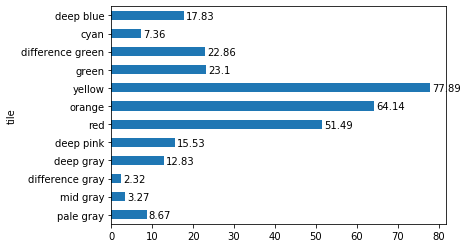

In [66]:
deltaE(measurement_to_fit, reference_cz.drop(['white', 'black'], dim='tile'))['deltaE'].to_series().plot.barh()
for i, v in enumerate(deltaE(measurement_to_fit, reference_cz.drop(['white', 'black'], dim='tile'))['deltaE'].values):
    plt.text(v + 0.5, i-0.2, v.round(decimals=2), color='k')

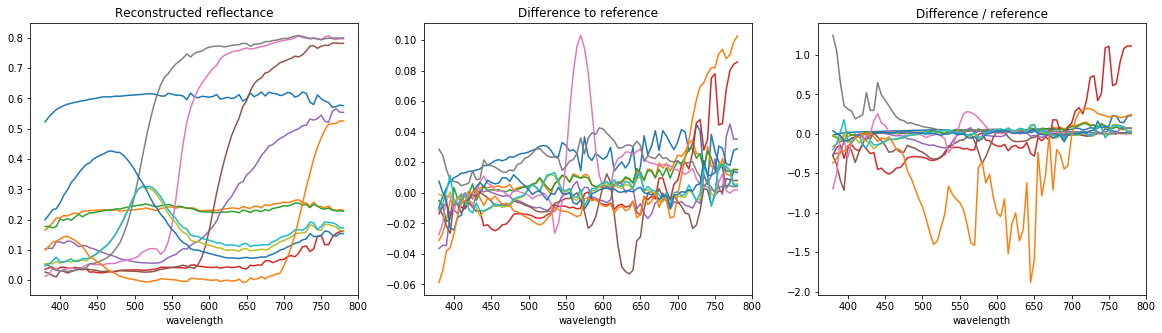

In [67]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
reconstruction.plot.line(ax=ax[0], x='wavelength', add_legend=False)
(reconstruction - reference_cz).plot.line(ax=ax[1], add_legend=False, x='wavelength')
((reconstruction - reference_cz)/reference_cz).plot.line(ax=ax[2], add_legend=False, x='wavelength')
ax[0].set_title('Reconstructed reflectance')
ax[1].set_title('Difference to reference')
ax[2].set_title('Difference / reference')
plt.show()

In [68]:
cz_coefs = fit_dataarray(measurement_to_fit, reference_cz)

In [69]:
reconstruction_cz = apply_model(measurement_to_fit, cz_coefs)

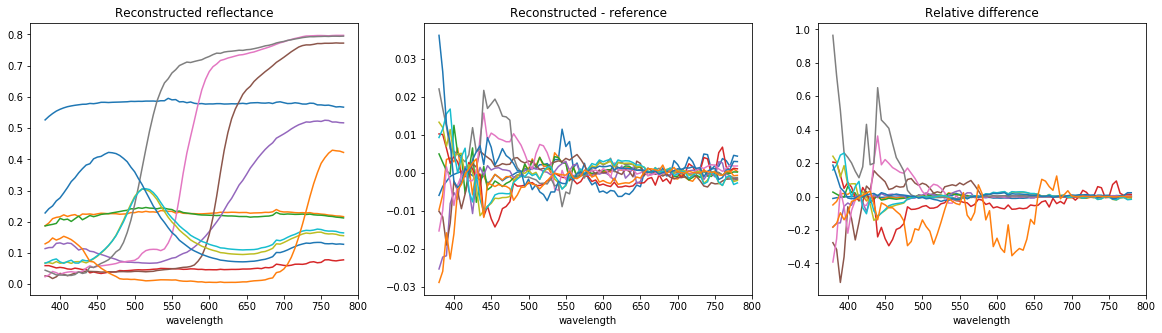

In [70]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
reconstruction_cz.plot.line(ax=ax[0], x='wavelength', add_legend=False)
(reconstruction_cz - reference_cz).plot.line(ax=ax[1], add_legend=False, x='wavelength')
((reconstruction_cz - reference_cz)/reference_cz).plot.line(ax=ax[2], add_legend=False, x='wavelength')
ax[0].set_title('Reconstructed reflectance')
ax[1].set_title('Reconstructed - reference')
ax[2].set_title('Relative difference')
plt.savefig('reconstructed_refCZ.png')
plt.show()

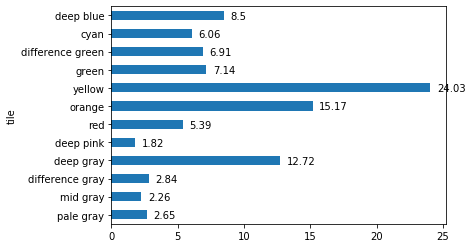

In [71]:
deltaE(reconstruction_cz, reference_cz.drop(['white', 'black'], dim='tile'))['deltaE'].to_series().plot.barh()
for i, v in enumerate(deltaE(reconstruction_cz, reference_cz.drop(['white', 'black'], dim='tile'))['deltaE'].values):
    plt.text(v+0.5, i-0.2, v.round(decimals=2), color='k')

In [86]:
cz_reco_df = reconstruction_cz.drop(['band', 'reference_filename', 'filename']).to_dataset('tile').to_dataframe()
cz_reco_df.to_csv('data/corrected_reflectances_cz.csv')

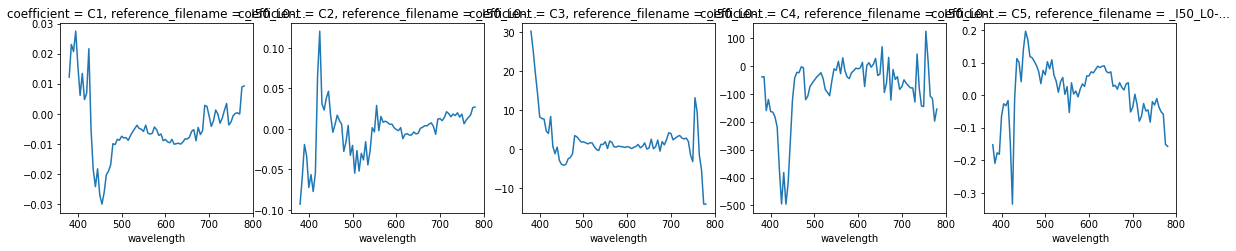

In [87]:
fig, ax = plt.subplots(ncols=5, figsize=(20,3.5))
for k, coef in enumerate(['C1', 'C2', 'C3', 'C4', 'C5']):
    cz_coefs.sel(coefficient=coef).plot.line(x='wavelength', ax=ax[k])
plt.show()

# Including Black & White

Include the black and one of the white tiles in the fit.

In [89]:
measured_with_bw = ds.isel(
    reference_filename=4
).where(
    (ds.distance=='near') & (ds.tile != 'None') & \
    (ds.filename != '_I50_L0-511_3-10-2018_10.59.48_White') & (ds.filename != '_I50_L0-511_3-10-2018_13.33.40_White'),
    drop=True
)['reflectance']
measured_with_bw = measured_with_bw.interp_like(reference_cz, method='linear') / PTFE_reflectance_factor_45_0()

In [90]:
measured_with_bw

<xarray.DataArray (tile: 14, wavelength: 81)>
array([[ 0.907125,  0.886608,  0.865552, ...,  0.855612,  0.855286,  0.855244],
       [ 0.138467,  0.122704,  0.102694, ...,  0.023669,  0.024693,  0.025798],
       [ 0.648741,  0.641327,  0.630698, ...,  0.576309,  0.576087,  0.575354],
       ..., 
       [ 0.257875,  0.232309,  0.203781, ...,  0.173079,  0.171909,  0.170912],
       [ 0.320161,  0.313674,  0.308617, ...,  0.131739,  0.130698,  0.129638],
       [ 0.213201,  0.204465,  0.194462, ...,  0.418741,  0.418864,  0.416356]])
Coordinates:
  * tile                (tile) object 'white' 'black' ... 'cyan' 'deep blue'
    filename            (tile) object '_I50_L0-511_3-10-2018_13.17.29_White' ... '_I50_L0-511_3-10-2018_13.30.50_12_DeepBlue_H'
    band                (wavelength) float64 2.507 3.509 4.51 ... 78.87 79.81
    reference_filename  <U35 '_I50_L0-511_3-10-2018_13.50.8_PTFE_'
  * wavelength          (wavelength) int64 380 385 390 395 ... 765 770 775 780

In [92]:
meas_bw_df = measured_with_bw.drop(['band', 'reference_filename', 'filename']).to_dataset('tile').to_dataframe()
meas_bw_df.to_csv('data/measured_with_bw.csv')

In [93]:
cz_coefs_with_bw = fit_dataarray(measured_with_bw, reference_cz)

In [94]:
reconstruction_cz_bw = apply_model(measured_with_bw, cz_coefs_with_bw)

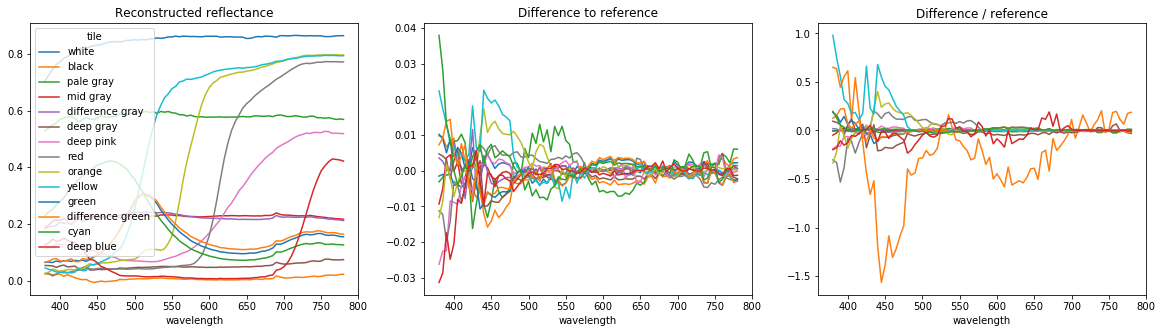

In [95]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))
reconstruction_cz_bw.plot.line(ax=ax[0], x='wavelength')
(reconstruction_cz_bw - reference_cz).plot.line(ax=ax[1], add_legend=False, x='wavelength')
((reconstruction_cz_bw - reference_cz)/reference_cz).plot.line(ax=ax[2], add_legend=False, x='wavelength')
ax[0].set_title('Reconstructed reflectance')
ax[1].set_title('Difference to reference')
ax[2].set_title('Difference / reference')
plt.show()

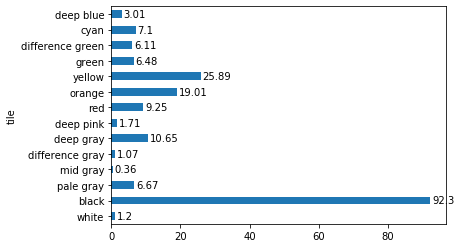

In [96]:
deltaE(reconstruction_cz_bw, reference_cz)['deltaE'].to_series().plot.barh()
for i, v in enumerate(deltaE(reconstruction_cz_bw, reference_cz)['deltaE'].values):
    plt.text(v+0.5, i-0.2, v.round(decimals=2), color='k')
plt.show()

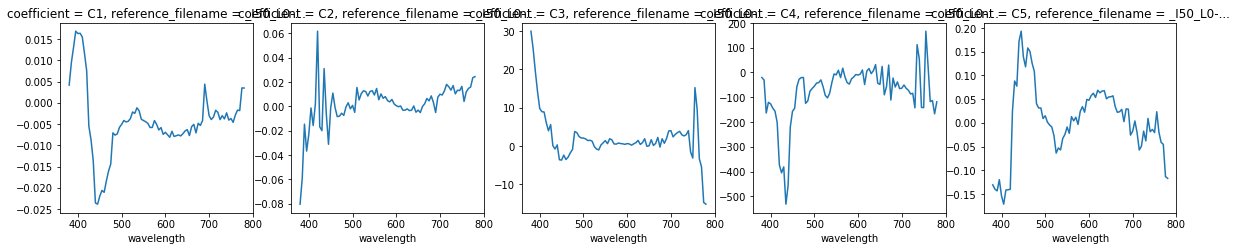

In [97]:
fig, ax = plt.subplots(ncols=5, figsize=(20,3.5))
for k, coef in enumerate(['C1', 'C2', 'C3', 'C4', 'C5']):
    cz_coefs_with_bw.sel(coefficient=coef).plot.line(x='wavelength', ax=ax[k])
plt.show()

In [99]:
reconstruction_with_bw_df = reconstruction_cz_bw.drop(['band', 'reference_filename', 'filename']).to_dataset('tile').to_dataframe()
reconstruction_with_bw_df.to_csv('data/reconstruction_with_bw.csv')